In [1]:
#!pip install numpy
#!pip install scipy
#!pip install torch
#!pip install torch_geometric
#!pip install matplotlib
#!pip install scikit-learn
#!pip install pandas

In [2]:
# Install required packages.
import os
import torch
import numpy as np
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

# Helper function for visualization.
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

2.6.0


# Node Classification with Graph Neural Networks

[Previous: Introduction: Hands-on Graph Neural Networks](https://colab.research.google.com/drive/1h3-vJGRVloF5zStxL5I0rSy4ZUPNsjy8)

This tutorial will teach you how to apply **Graph Neural Networks (GNNs) to the task of node classification**.
Here, we are given the ground-truth labels of only a small subset of nodes, and want to infer the labels for all the remaining nodes (*transductive learning*).

To demonstrate, we make use of the `female connectome VNC` dataset, where nodes represent neurons.
Each node is described by a 1000-dimensional activity feature vector.
Two nodes are connected if there exists a connection between them.
The task is to infer the category of each document (2 in total).

In [3]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

In [4]:
from torch_geometric.data import Data
from torch_geometric.utils import to_dense_adj
import numpy as np


In [7]:
import pandas as pd

# Read the CSV file
df = pd.read_csv("FlyWire_data/female_connectome_graph.csv")

# Display the first few rows
print(df.head())


  From Node ID To Node Id  Weight
0         f933      f4810       4
1         f933      f4794      27
2         f933     f12413       3
3         f933      f4532      40
4         f933     f11948      11


In [8]:
num_nodes = int(np.max([np.max([int(x.lstrip('f')) for x in df['To Node Id']]), np.max([int(x.lstrip('f')) for x in df['From Node ID']])]))

In [9]:
to = np.array([int(to.lstrip('f')) -1 for to in df['To Node Id']])
fro = np.array([int(fro.lstrip('f')) -1 for fro in df['From Node ID']])
selfcons = np.where(to == fro)[0]

In [10]:
to = np.delete(to, selfcons)
fro = np.delete(fro, selfcons)


In [11]:
edge_index = torch.tensor(np.array([to, fro]))

In [12]:
num_nodes

18524

In [13]:
#edge_attr = torch.tensor(df['Weight'])

In [14]:
# Generate a vector of size 5 with P(1) = 0.6 and P(-1) = 0.4
#cluster here
#weak and strong
#cell type --> strength is a rule
#cell type --> connecdtivity
y = torch.tensor(np.random.choice([-1, 1], size=num_nodes, p=[0.50, 0.50]))

In [15]:
W0 = to_dense_adj(edge_index, max_num_nodes=num_nodes)

In [16]:
#W = to_dense_adj(edge_index, max_num_nodes=num_nodes, edge_attr=edge_attr)[0,:,:]
W = to_dense_adj(edge_index, max_num_nodes=num_nodes)[0,:,:]

In [17]:
# Multiply each row by the corresponding element in v
W = W * y.view(-1, 1)  # Reshape v to [3, 1] for broadcasting

In [18]:
W = W.float()  # or A.to(torch.float32)
norm_W = torch.norm(W, p='fro')  # Equivalent to p=2 for matrices

# Scale the matrix to have norm 1
W_scaled = 500 * W / norm_W

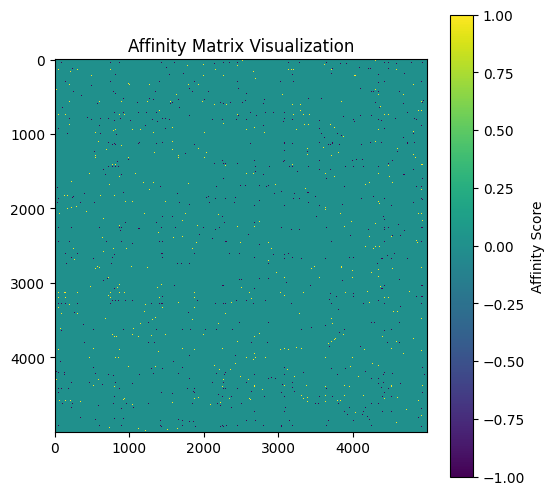

In [19]:
import matplotlib.pyplot as plt

# Plot using Matplotlib
plt.figure(figsize=(6, 6))
plt.imshow(torch.sign(W_scaled[0:4999,0:4999]), cmap='viridis', interpolation='nearest')
plt.colorbar(label="Affinity Score")
plt.title("Affinity Matrix Visualization")
plt.show()

In [20]:
import torch.nn as nn

# Define RNN parameters
input_size = 1     # Number of input features
hidden_size = num_nodes   # Number of hidden units
num_layers = 1     # Single-layer RNN
time_steps = 1_000   # Number of time steps
batch_size = 1     # One sequence at a time

# Create an RNN model
rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)

# Manually set the weight matrices (connectivity matrix)
with torch.no_grad(): 
    num_ones = hidden_size // 10
    ones = torch.ones(num_ones, input_size)
    num_zeros = hidden_size - num_ones
    zeros = torch.zeros(num_zeros, input_size)
    rnn.weight_ih_l0.copy_(torch.cat([ones, zeros], dim=0))  # Input-to-hidden weights
    rnn.weight_hh_l0.copy_(W_scaled) # Hidden-to-hidden weights
    rnn.bias_ih_l0.zero_()  # Set biases to zero
    rnn.bias_hh_l0.zero_()

# Initialize hidden state
h_t = torch.zeros(num_layers, batch_size, hidden_size)
# List to store hidden states
hidden_states = []

# Simulate 100 time steps
for t in range(time_steps):
    x_t = torch.ones(batch_size, 1, input_size)  # Single time step input
    out, h_t = rnn(x_t, h_t)  # Forward pass through RNN
    # Save hidden state at this time step
    hidden_states.append(h_t.clone())  

hidden_states = torch.cat(hidden_states, dim=0).squeeze().t()

(-1.1, 1.1)

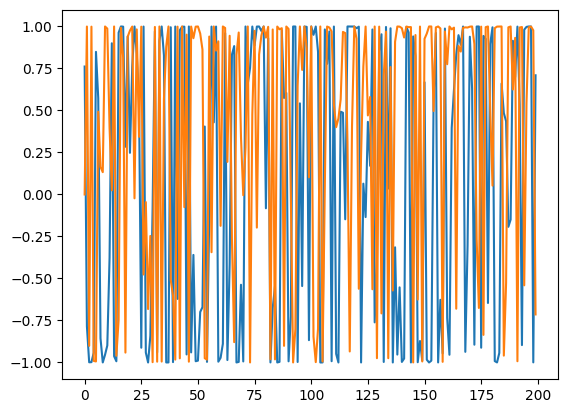

In [21]:
plt.plot(hidden_states[0][0:200].detach().numpy())
#plt.plot(hidden_states[1][0:200].detach().numpy())
#plt.plot(hidden_states[10000][0:200].detach().numpy())
plt.plot(hidden_states[1852][0:200].detach().numpy())
plt.ylim(-1.1, 1.1)         # Set y-axis limits from 0 to 1

In [22]:
# Define graph parameters
num_classes = 2
train_ratio = 0.2  # 70% of nodes for training
num_features = time_steps

# Create train and test masks
num_train = int(train_ratio * num_nodes)
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)

# Assign random train and test nodes
perm = torch.randperm(num_nodes)
train_mask[perm[:num_train]] = True
test_mask[perm[num_train:]] = True

y2 = torch.where(y == -1, torch.tensor(0), torch.tensor(1))

# Create PyG Data object
#data = Data(x=hidden_states, edge_index=edge_index, y=y2, train_mask=train_mask, test_mask=test_mask, edge_attr=edge_attr)
data = Data(x=hidden_states.detach(), edge_index=edge_index, y=y2, train_mask=train_mask, test_mask=test_mask)

# Print dataset info
print(f'Number of nodes: {data.x.shape[0]}')
print(f'Number of edges: {data.edge_index.shape[1]}')
print(f'Node features shape: {data.x.shape}')
print(f'Node labels shape: {data.y.shape}')
print(f'Train mask: {data.train_mask}')
print(f'Test mask: {data.test_mask}')
print(f'Num training nodes: {data.train_mask.sum().item()}')
print(f'Num testing nodes: {data.test_mask.sum().item()}')


Number of nodes: 18524
Number of edges: 2190669
Node features shape: torch.Size([18524, 1000])
Node labels shape: torch.Size([18524])
Train mask: tensor([False, False,  True,  ..., False, False, False])
Test mask: tensor([ True,  True, False,  ...,  True,  True,  True])
Num training nodes: 3704
Num testing nodes: 14820


In [23]:
#print()
#print(f'Dataset: {dataset}:')
#print('======================')
#print(f'Number of graphs: {len(dataset)}')
#print(f'Number of features: {dataset.num_features}')
#print(f'Number of classes: {dataset.num_classes}')

#data = dataset[0]  # Get the first graph object.

print()
print(data)
print('===========================================================================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Data(x=[18524, 1000], edge_index=[2, 2190669], y=[18524], train_mask=[18524], test_mask=[18524])
Number of nodes: 18524
Number of edges: 2190669
Average node degree: 118.26
Number of training nodes: 3704
Training node label rate: 0.20
Has isolated nodes: True
Has self-loops: False
Is undirected: False


In [29]:
from torch_geometric.transforms import GDC

gdc = GDC(
    self_loop_weight=1,
    normalization_in='sym',
    normalization_out='col',
    diffusion_kwargs=dict(method='ppr', alpha=0.15, eps=1e-4),
    sparsification_kwargs=dict(method='threshold', eps=1e-4),
    exact=True
)

In [30]:
from torch_sparse import spmm

# 1) Apply GDC to get a diffused adjacency:
data_diffused = gdc(data)  # This modifies edge_index, edge_attr in a new Data object.

# data_diffused.edge_index is the "diffused" adjacency structure
# data_diffused.edge_attr (if not None) are the corresponding weights

# 2) Multiply the new adjacency by your features:
edge_index = data_diffused.edge_index
edge_weight = data_diffused.edge_attr  # or None if unweighted
X = data.x

# spmm performs sparse matrix multiplication:  X_new = A * X
# where A is encoded by (edge_index, edge_weight)
X_diffused = spmm(edge_index, edge_weight, X.size(0), X.size(0), X)

# Now X_diffused has the "diffused" features for each node
data.x = X_diffused  # Overwrite original features if desired

: 

In [24]:
from torch_geometric.utils import degree

# Compute node degrees
node_degrees = degree(edge_index[0], num_nodes=edge_index.max().item() + 1)  # Compute degree for each node

# Find nodes with exactly 2 connections
nodes_with_4_connections = (node_degrees == 8).nonzero(as_tuple=True)[0]

print("Node degrees:", node_degrees)
print("Nodes with exactly 4 connections:", nodes_with_4_connections.tolist())


Node degrees: tensor([143., 141.,  23.,  ...,   5., 111.,  94.])
Nodes with exactly 4 connections: [453, 571, 640, 1065, 2122, 2226, 2264, 2734, 2774, 2987, 3005, 3028, 3246, 3429, 3568, 3717, 3798, 3928, 3946, 4596, 4701, 4786, 4873, 5294, 5599, 5738, 5999, 6320, 6324, 6353, 6784, 6854, 6909, 7528, 7660, 7722, 7790, 8040, 8428, 8549, 9003, 9014, 9118, 9405, 9714, 9751, 9757, 9913, 9984, 10504, 10523, 10535, 10767, 11289, 11293, 11358, 12221, 12348, 12529, 12597, 12849, 13049, 13219, 13385, 13391, 13409, 13411, 13475, 13715, 13749, 13768, 13919, 14039, 14418, 14591, 14625, 14689, 14773, 14785, 14964, 15883, 15994, 15995, 16443, 16608, 16830, 17084, 17295, 17888, 17965, 18057, 18126, 18367, 18436, 18517]


In [25]:
def find_neighbors(node, edge_index):
    """Find all nodes connected to a given node"""
    mask = (edge_index[0] == node) | (edge_index[1] == node)  # Find edges where node appears
    connected_edges = edge_index[:, mask]  # Extract edges containing the node
    connected_nodes = torch.unique(connected_edges)  # Get unique node IDs
    connected_nodes = connected_nodes[connected_nodes != node]  # Remove original node
    return connected_nodes

In [26]:
target_node = nodes_with_4_connections.tolist()[0]
connected_nodes = find_neighbors(target_node, data.edge_index)

In [27]:
target_node = nodes_with_4_connections.tolist()[4]
connected_nodes2 = find_neighbors(target_node, data.edge_index)

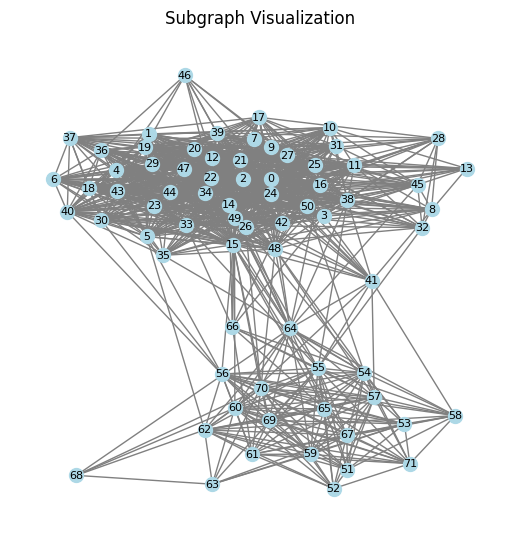

In [28]:
from torch_geometric.utils import subgraph, to_networkx
import networkx as nx

# Select subset of nodes (e.g., nodes 1, 2, 3)
subset_nodes = torch.cat((nodes_with_4_connections[0:1], connected_nodes, connected_nodes2))

# Extract subgraph
sub_edge_index, _ = subgraph(subset_nodes, data.edge_index, relabel_nodes=True)

# Create subgraph Data object
subgraph_data = Data(edge_index=sub_edge_index, x=data.x[subset_nodes])

# Convert to NetworkX for visualization
G = to_networkx(subgraph_data, to_undirected=True)

# Draw subgraph
plt.figure(figsize=(5, 5))
nx.draw(G, with_labels=True, node_color="lightblue", edge_color="gray", node_size=100, font_size=8)
plt.xticks([])
plt.yticks([])
plt.title("Subgraph Visualization")
plt.show()

## Training a Multi-layer Perception Network (MLP)

In theory, we should be able to infer the category of a neuron solely based on its content, *i.e.* its actvity feature representation, without taking any relational information into account.

Let's verify that by constructing a simple MLP that solely operates on input node features (using shared weights across all nodes):

In [75]:
import torch
from torch.nn import Linear
import torch.nn.functional as F


class MLP(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(12345)
        self.lin1 = Linear(num_features, hidden_channels)
        self.lin2 = Linear(hidden_channels, num_classes)

    def forward(self, x):
        x = self.lin1(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return x

model = MLP(hidden_channels=16)
print(model)

MLP(
  (lin1): Linear(in_features=1000, out_features=16, bias=True)
  (lin2): Linear(in_features=16, out_features=2, bias=True)
)


Our MLP is defined by two linear layers and enhanced by [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html?highlight=relu#torch.nn.ReLU) non-linearity and [dropout](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html?highlight=dropout#torch.nn.Dropout).
Here, we first reduce the 1433-dimensional feature vector to a low-dimensional embedding (`hidden_channels=16`), while the second linear layer acts as a classifier that should map each low-dimensional node embedding to one of the 7 classes.

Let's train our simple MLP by following a similar procedure as described in [the first part of this tutorial](https://colab.research.google.com/drive/1h3-vJGRVloF5zStxL5I0rSy4ZUPNsjy8).
We again make use of the **cross entropy loss** and **Adam optimizer**.
This time, we also define a **`test` function** to evaluate how well our final model performs on the test node set (which labels have not been observed during training).

In [76]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = MLP(hidden_channels=16)
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  # Define optimizer.

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test():
      model.eval()
      out = model(data.x)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc

for epoch in range(1, 201):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

<IPython.core.display.Javascript object>

Epoch: 001, Loss: 0.7599
Epoch: 002, Loss: 1.2037
Epoch: 003, Loss: 1.0771
Epoch: 004, Loss: 0.7685
Epoch: 005, Loss: 0.5021
Epoch: 006, Loss: 0.5062
Epoch: 007, Loss: 0.5751
Epoch: 008, Loss: 0.5403
Epoch: 009, Loss: 0.4684
Epoch: 010, Loss: 0.4581
Epoch: 011, Loss: 0.4677
Epoch: 012, Loss: 0.4290
Epoch: 013, Loss: 0.3885
Epoch: 014, Loss: 0.3369
Epoch: 015, Loss: 0.3035
Epoch: 016, Loss: 0.3120
Epoch: 017, Loss: 0.3256
Epoch: 018, Loss: 0.3146
Epoch: 019, Loss: 0.2774
Epoch: 020, Loss: 0.2612
Epoch: 021, Loss: 0.2560
Epoch: 022, Loss: 0.2410
Epoch: 023, Loss: 0.2260
Epoch: 024, Loss: 0.2189
Epoch: 025, Loss: 0.1987
Epoch: 026, Loss: 0.1914
Epoch: 027, Loss: 0.1775
Epoch: 028, Loss: 0.1649
Epoch: 029, Loss: 0.1625
Epoch: 030, Loss: 0.1527
Epoch: 031, Loss: 0.1462
Epoch: 032, Loss: 0.1348
Epoch: 033, Loss: 0.1368
Epoch: 034, Loss: 0.1344
Epoch: 035, Loss: 0.1325
Epoch: 036, Loss: 0.1204
Epoch: 037, Loss: 0.1096
Epoch: 038, Loss: 0.1080
Epoch: 039, Loss: 0.1061
Epoch: 040, Loss: 0.0988


After training the model, we can call the `test` function to see how well our model performs on unseen labels.
Here, we are interested in the accuracy of the model, *i.e.*, the ratio of correctly classified nodes:

In [78]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.9806


## Training a Graph Neural Network (GNN)

We can easily convert our MLP to a GNN by swapping the `torch.nn.Linear` layers with PyG's GNN operators.

Following-up on [the first part of this tutorial](https://colab.research.google.com/drive/1h3-vJGRVloF5zStxL5I0rSy4ZUPNsjy8), we replace the linear layers by the [`GCNConv`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GCNConv) module.
To recap, the **GCN layer** ([Kipf et al. (2017)](https://arxiv.org/abs/1609.02907)) is defined as

$$
\mathbf{x}_v^{(\ell + 1)} = \mathbf{W}^{(\ell + 1)} \sum_{w \in \mathcal{N}(v) \, \cup \, \{ v \}} \frac{1}{c_{w,v}} \cdot \mathbf{x}_w^{(\ell)}
$$

where $\mathbf{W}^{(\ell + 1)}$ denotes a trainable weight matrix of shape `[num_output_features, num_input_features]` and $c_{w,v}$ refers to a fixed normalization coefficient for each edge.
In contrast, a single `Linear` layer is defined as

$$
\mathbf{x}_v^{(\ell + 1)} = \mathbf{W}^{(\ell + 1)} \mathbf{x}_v^{(\ell)}
$$

which does not make use of neighboring node information.

In [ ]:
#GAT GIN?
from torch_geometric.nn import GCNConv


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GCN(hidden_channels=16)
print(model)

GCN(
  (conv1): GCNConv(1000, 16)
  (conv2): GCNConv(16, 2)
)


Let's visualize the node embeddings of our **untrained** GCN network.
For visualization, we make use of [**TSNE**](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) to embed our 7-dimensional node embeddings onto a 2D plane.

In [80]:
print("x shape:", data.x.shape)  # Should be [num_nodes, num_features]
print("max index in edge_index:", edge_index.max().item())

x shape: torch.Size([18524, 1000])
max index in edge_index: 18523


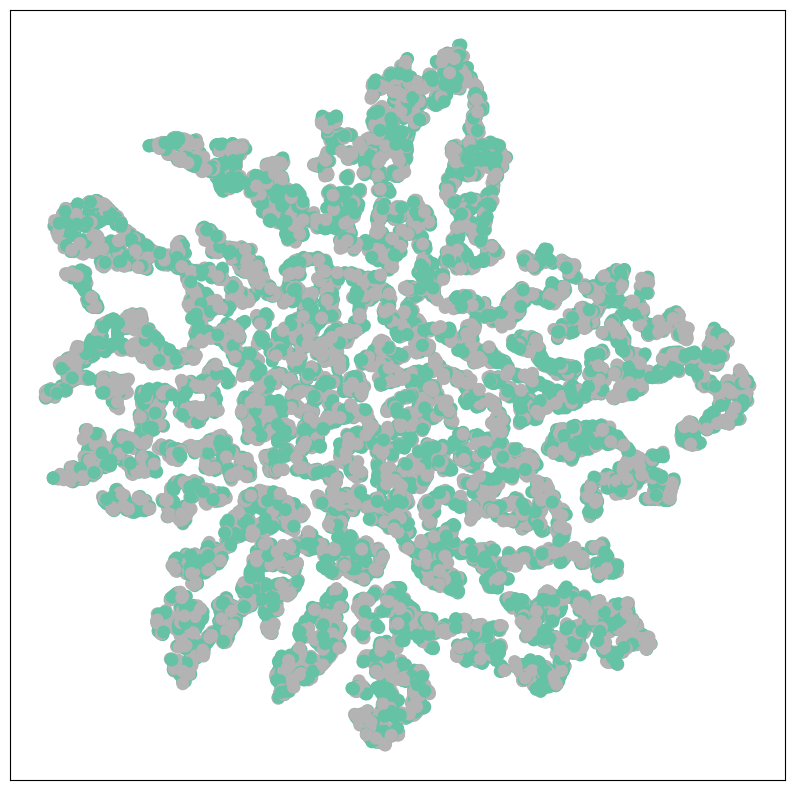

In [81]:
model = GCN(hidden_channels=16)
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)

We certainly can do better by training our model.
The training and testing procedure is once again the same, but this time we make use of the node features `x` **and** the graph connectivity `edge_index` as input to our GCN model.

In [82]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = GCN(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x, data.edge_index)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test():
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc


for epoch in range(1, 101):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

<IPython.core.display.Javascript object>

Epoch: 001, Loss: 0.6955
Epoch: 002, Loss: 0.7469
Epoch: 003, Loss: 0.7587
Epoch: 004, Loss: 0.6995
Epoch: 005, Loss: 0.7089
Epoch: 006, Loss: 0.6978
Epoch: 007, Loss: 0.6917
Epoch: 008, Loss: 0.6974
Epoch: 009, Loss: 0.6986
Epoch: 010, Loss: 0.6949
Epoch: 011, Loss: 0.6917
Epoch: 012, Loss: 0.6948
Epoch: 013, Loss: 0.6938
Epoch: 014, Loss: 0.6925
Epoch: 015, Loss: 0.6927
Epoch: 016, Loss: 0.6914
Epoch: 017, Loss: 0.6911
Epoch: 018, Loss: 0.6890
Epoch: 019, Loss: 0.6888
Epoch: 020, Loss: 0.6887
Epoch: 021, Loss: 0.6905
Epoch: 022, Loss: 0.6895
Epoch: 023, Loss: 0.6879
Epoch: 024, Loss: 0.6894
Epoch: 025, Loss: 0.6869
Epoch: 026, Loss: 0.6867
Epoch: 027, Loss: 0.6859
Epoch: 028, Loss: 0.6857
Epoch: 029, Loss: 0.6839
Epoch: 030, Loss: 0.6834
Epoch: 031, Loss: 0.6832
Epoch: 032, Loss: 0.6825
Epoch: 033, Loss: 0.6845
Epoch: 034, Loss: 0.6830
Epoch: 035, Loss: 0.6848
Epoch: 036, Loss: 0.6826
Epoch: 037, Loss: 0.6836
Epoch: 038, Loss: 0.6817
Epoch: 039, Loss: 0.6823
Epoch: 040, Loss: 0.6836


After training the model, we can check its test accuracy:

In [83]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.5073


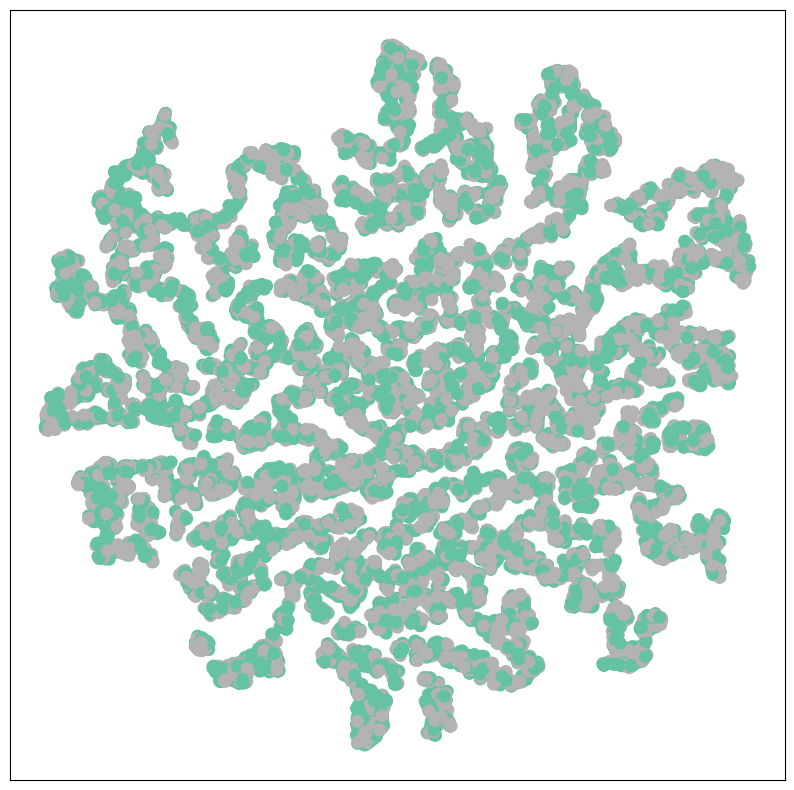

In [84]:
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)